In [39]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from astropy.io import fits,ascii
import pandas as pd
import cmasher as cmr
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
import pingouin

In [63]:
sample = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_kinemetry_sample_s05.csv")
prospect = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
galfit = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_GalfitSersicCat_v0.1.csv")
ssp = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_ApertureSpectra_StellarPops_V1.0_SPV.csv")
bpt = pd.read_csv('/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_kinemetry_sample_BPT.csv')
master = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_master_source_catalogue.csv",skiprows=16)
prospect = prospect[prospect['MAGPIID'].isin(sample["MAGPIID"])]
galfit = galfit[galfit["MAGPIID"].isin(sample["MAGPIID"])]
bpt = bpt[bpt["MAGPIID"].isin(sample["MAGPIID"])]
ssp = ssp[ssp["MAGPIID"].isin(sample["MAGPIID"])]
master = master[master['MAGPIID'].isin(sample["MAGPIID"])]

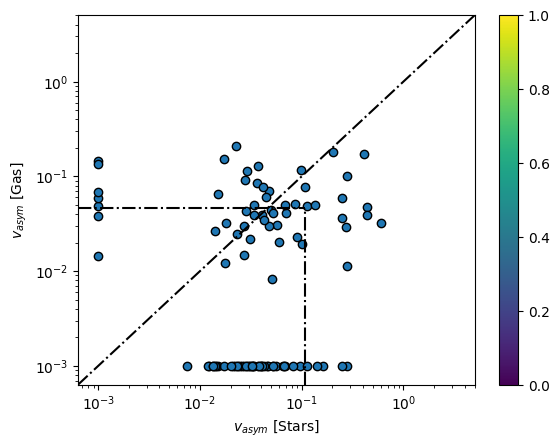

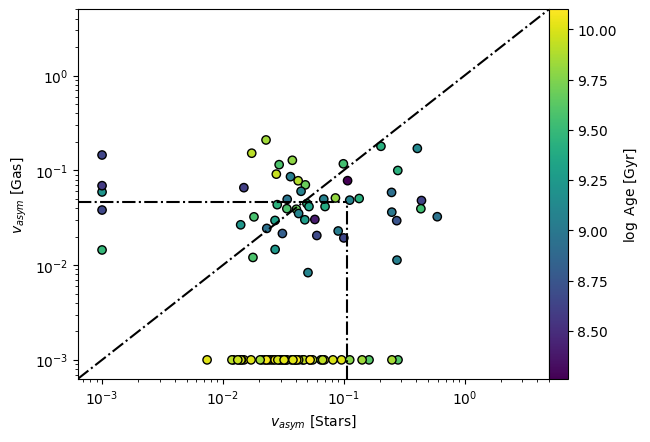

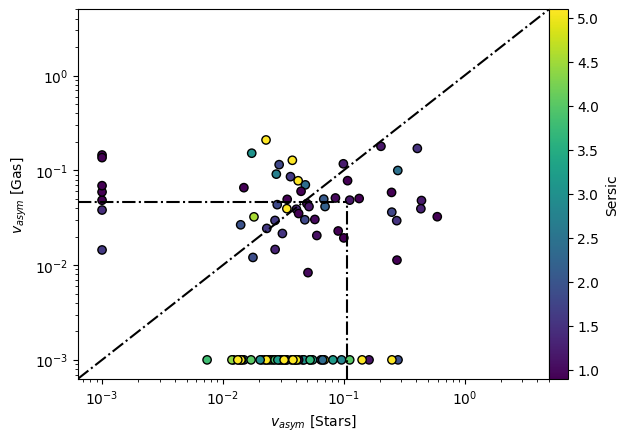

In [64]:
vs = sample["v_asym_s"].to_numpy()
vg = sample["v_asym_g"].to_numpy()
age = ssp["logage_LW_1re"].to_numpy()
vs[np.isnan(vs)]=1e-3
vg[np.isnan(vg)]=1e-3

fig,ax=plt.subplots()
p=ax.scatter(vs,vg,ec="k")
ax.plot(np.logspace(-3.2,0.7),np.logspace(-3.2,0.7),ls="dashdot",color="k")
ax.set_xlabel(r"$v_{asym}$ [Stars]")
ax.set_ylabel(r"$v_{asym}$ [Gas]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(10**(-3.2),10**(0.7))
ax.set_ylim(10**(-3.2),10**(0.7))
ax.vlines(x=np.std(vs[vs>2e-3]),ymin=10**(-3.2),ymax=np.std(vg[vg>2e-3]),ls="dashdot",color="k")
ax.hlines(y=np.std(vg[vg>2e-3]),xmin=10**(-3.2),xmax=np.std(vs[vs>2e-3]),ls="dashdot",color="k")
#cbar = plt.colorbar(p,ax=ax,fraction=0.05,pad=0.00,label=r"$\log$ Age [Gyr]")
#cbar.ax.set_yticklabels([8.95,9.05,9.15,9.25,9.35,9.45,9.55,9.65,9.75])
plt.savefig("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_Plots/plots/paper2/s05_gas_stars.pdf",bbox_inches="tight")

fig,ax=plt.subplots()
p=ax.scatter(vs,vg,c=age,ec="k")
ax.plot(np.logspace(-3.2,0.7),np.logspace(-3.2,0.7),ls="dashdot",color="k")
ax.set_xlabel(r"$v_{asym}$ [Stars]")
ax.set_ylabel(r"$v_{asym}$ [Gas]")
ax.set_xscale("log")
ax.set_yscale("log")
cbar = plt.colorbar(p,ax=ax,fraction=0.05,pad=0.00,label=r"$\log$ Age [Gyr]")
ax.set_xlim(10**(-3.2),10**(0.7))
ax.set_ylim(10**(-3.2),10**(0.7))
ax.vlines(x=np.std(vs[vs>2e-3]),ymin=10**(-3.2),ymax=np.std(vg[vg>2e-3]),ls="dashdot",color="k")
ax.hlines(y=np.std(vg[vg>2e-3]),xmin=10**(-3.2),xmax=np.std(vs[vs>2e-3]),ls="dashdot",color="k")
#cbar.ax.set_yticklabels([8.95,9.05,9.15,9.25,9.35,9.45,9.55,9.65,9.75])
plt.savefig("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_Plots/plots/paper2/s05_gas_stars_age.pdf",bbox_inches="tight")

fig,ax=plt.subplots()
p=ax.scatter(vs,vg,c=galfit["n"],vmin=0.9,vmax=5.1,ec="k")
ax.plot(np.logspace(-3.2,0.7),np.logspace(-3.2,0.7),ls="dashdot",color="k")
ax.set_xlabel(r"$v_{asym}$ [Stars]")
ax.set_ylabel(r"$v_{asym}$ [Gas]")
ax.set_xscale("log")
ax.set_yscale("log")
plt.colorbar(p,ax=ax,fraction=0.05,pad=0.00,label="Sersic")
ax.set_xlim(10**(-3.2),10**(0.7))
ax.set_ylim(10**(-3.2),10**(0.7))
ax.vlines(x=np.std(vs[vs>2e-3]),ymin=10**(-3.2),ymax=np.std(vg[vg>2e-3]),ls="dashdot",color="k")
ax.hlines(y=np.std(vg[vg>2e-3]),xmin=10**(-3.2),xmax=np.std(vs[vs>2e-3]),ls="dashdot",color="k")
plt.savefig("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_Plots/plots/paper2/s05_gas_stars_sersic.pdf",bbox_inches="tight")

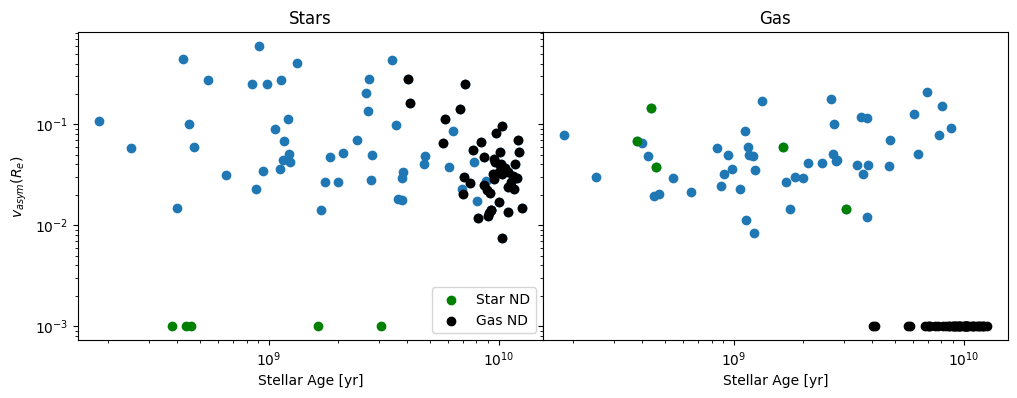

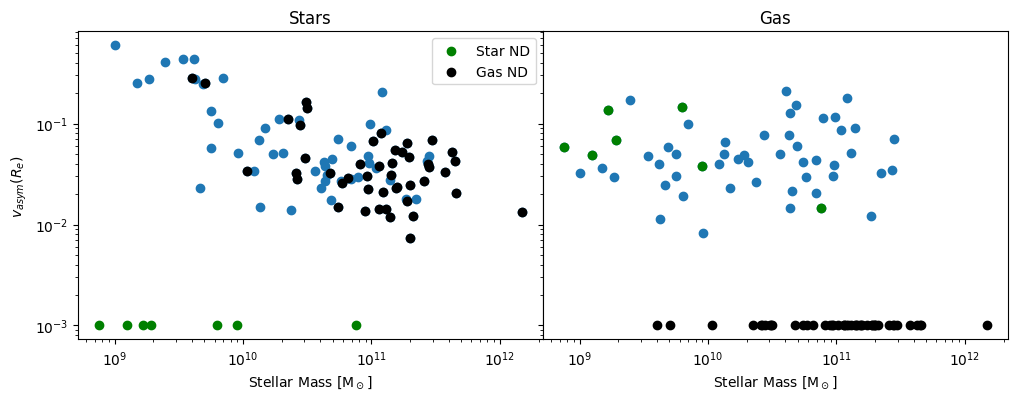

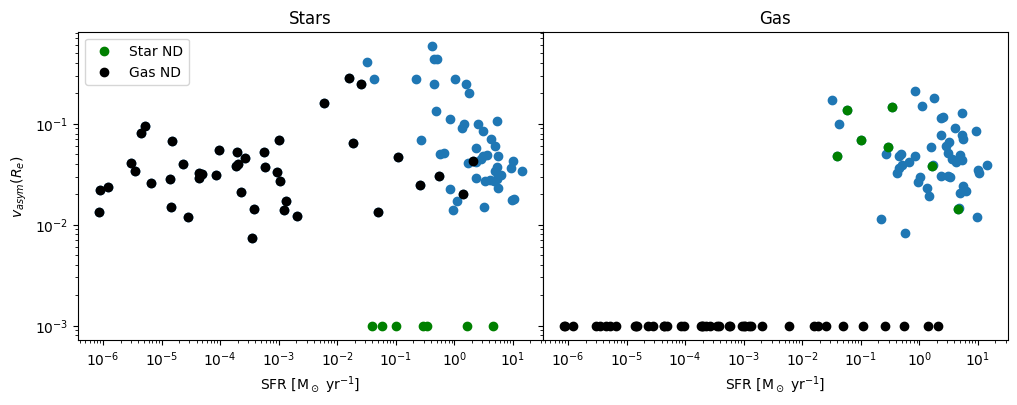

In [53]:
fig,(ax1,ax2) = plt.subplots(1,2,sharey="row",figsize=(12,4))
ax1.scatter(10**(age[vs>2e-3]),vs[vs>2e-3])
ax1.scatter(10**(age[vs<2e-3]),vs[vs<2e-3],c="g")
ax1.scatter(10**(age[vg<2e-3]),vs[vg<2e-3],c="k")
ax1.set_yscale("log")
ax2.scatter(10**(age[vg>2e-3]),vg[vg>2e-3])
ax2.scatter(10**(age[vg<2e-3]),vg[vg<2e-3],c="k")
ax2.scatter(10**(age[vs<2e-3]),vg[vs<2e-3],c="g")
ax2.set_yscale("log")
ax1.set_xscale("log")
ax2.set_xscale("log")
ax1.set_title("Stars")
ax2.set_title("Gas")
ax1.set_ylabel(r"$v_{asym}(R_e)$")
ax1.set_xlabel(r"Stellar Age [yr]")
ax2.set_xlabel(r"Stellar Age [yr]")
plt.subplots_adjust(wspace=0)
plt.savefig("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_Plots/plots/paper2/age_vs_asym.pdf",bbox_inches="tight")

mass = prospect["StellarMass_median"].to_numpy()
fig,(ax1,ax2) = plt.subplots(1,2,sharey="row",figsize=(12,4))
ax1.scatter(mass[vs>2e-3],vs[vs>2e-3])
ax1.scatter(mass[vs<2e-3],vs[vs<2e-3],c="g")
ax1.scatter(mass[vg<2e-3],vs[vg<2e-3],c="k")
ax1.set_yscale("log")
ax2.scatter(mass[vg>2e-3],vg[vg>2e-3])
ax2.scatter(mass[vg<2e-3],vg[vg<2e-3],c="k")
ax2.scatter(mass[vs<2e-3],vg[vs<2e-3],c="g")
ax2.set_yscale("log")
ax2.set_xscale("log")
ax1.set_xscale("log")
ax1.set_title("Stars")
ax2.set_title("Gas")
ax1.set_ylabel(r"$v_{asym}(R_e)$")
ax1.set_xlabel(r"Stellar Mass [M$_\odot$]")
ax2.set_xlabel(r"Stellar Mass [M$_\odot$]")
plt.subplots_adjust(wspace=0)
plt.savefig("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_Plots/plots/paper2/age_vs_mass.pdf",bbox_inches="tight")

SFR = bpt["SFR, dust corrected"].to_numpy()
fig,(ax1,ax2) = plt.subplots(1,2,sharey="row",figsize=(12,4))
ax1.scatter(SFR[vs>2e-3],vs[vs>2e-3])
ax1.scatter(SFR[vs<2e-3],vs[vs<2e-3],c="g")
ax1.scatter(SFR[vg<2e-3],vs[vg<2e-3],c="k")
ax1.set_yscale("log")
ax2.scatter(SFR[vg>2e-3],vg[vg>2e-3])
ax2.scatter(SFR[vg<2e-3],vg[vg<2e-3],c="k")
ax2.scatter(SFR[vs<2e-3],vg[vs<2e-3],c="g")
ax2.set_yscale("log")
ax2.set_xscale("log")
ax1.set_xscale("log")
ax1.set_title("Stars")
ax2.set_title("Gas")
ax1.set_ylabel(r"$v_{asym}(R_e)$")
ax1.set_xlabel(r"SFR [M$_\odot$ yr$^{-1}$]")
ax2.set_xlabel(r"SFR [M$_\odot$ yr$^{-1}$]")
plt.subplots_adjust(wspace=0)
plt.savefig("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_Plots/plots/paper2/age_vs_mass.pdf",bbox_inches="tight")

In [43]:
scipy.stats.pearsonr(age[vs>2e-3],np.log10(vs[vs>2e-3]))

PearsonRResult(statistic=-0.42462190668552696, pvalue=2.214554596033841e-05)

In [44]:
vgg = vg[~np.isnan(age)]
agee = age[~np.isnan(age)]

scipy.stats.pearsonr(agee[vgg>2e-3],np.log10(vgg[vgg>2e-3]))

PearsonRResult(statistic=0.2607563406283943, pvalue=0.06189105428414788)

In [45]:
np.log10(age[vg>2e-3])

array([0.95389397, 0.9565221 , 0.91703643,        nan, 0.95221033,
       0.93638559, 0.98558875, 0.95850255, 0.96588579, 0.92423518,
       0.97485957, 0.93580832, 0.98131221, 0.95815339, 0.98589894,
       0.96696822, 0.98124205, 0.9601204 , 0.99594957, 0.95723577,
       0.96504714, 0.97235018, 0.99128967, 0.97531384, 0.9370996 ,
       0.95553694, 0.9685482 ,        nan, 0.9375884 , 0.95070335,
       0.95864735, 0.95668819, 0.97458976, 0.97423326, 0.97515105,
       0.95293379, 0.96446807, 0.93821401, 0.93446398, 0.99524077,
       0.97927505, 0.9929422 , 0.97711713, 0.94510382, 0.969431  ,
       0.99752128, 0.98018775, 0.93348373, 0.94129752, 0.98053956,
       0.95734792, 0.98144296, 0.99053835, 0.95147763])

In [46]:
np.std(vg[vg>2e-3])

0.04614801155441706

In [47]:
np.std(vs[vs>2e-3])

0.10706286674066053

In [48]:
env = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/kinemetry_sample_env.csv")

master = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/"
                     "MAGPI_master_source_catalogue.csv",skiprows=16)
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
#master = master[master["MAGPIID"].isin(sample["MAGPIID"])]
gal = np.zeros(len(env))
d1_ = np.zeros(len(env))
for i in range(len(env)):
    group = env[env['GroupName'].isin([env["GroupName"].to_numpy()[i]])]
    group_master = master[master["MAGPIID"].isin(group["MAGPIID"])]
    #print([env_sample['MAGPIID'].to_numpy()[i]])
    sample_master = master[master['MAGPIID'].isin([env['MAGPIID'].to_numpy()[i]])]
    x = group_master["xmax"].to_numpy()
    y = group_master["ymax"].to_numpy()
    #print(x,y)
    x0 = sample_master["xmax"].to_numpy()[0]
    y0 = sample_master["ymax"].to_numpy()[0]
    z = sample_master["z"].to_numpy()[0]
    gal[i] = sample_master["MAGPIID"].to_numpy()[0]
    #print(x0,y0)
    d1 = np.sqrt((x-x0)**2 + (y-y0)**2)
    d1 = np.min(d1[d1>0])
    cd = cosmo.comoving_distance(z).to(u.kpc).value
    d1 = np.radians(d1*(0.2/3600))
    d1 = d1*cd
    d1_[i] = d1
env["d1,kpc"] = d1_
env.to_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/kinemetry_sample_env.csv")